In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
import random as rd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
from sklearn.metrics import confusion_matrix
from stargazer.stargazer import Stargazer

Using TensorFlow backend.


## Cleaning the Dataset

The original dataset is only available in Stata (.dta) format.


In [2]:
beeps = pd.DataFrame(pd.read_stata("/Users/johannes/Desktop/Minerva/Impact Evaluation/India-2014-full-data_NAs.dta"))

In [3]:
## subselect the variables to work with
data = beeps[['j30f', "b7a", 'a2', 'a3', 'a4a',"a6a", "a7a","a7", "b1", "b2c", "b4a","b5" , "b6", "k3a", "j7a", "j7b","l6a"]]

In [4]:
data.j30f.unique()

[No obstacle, Minor obstacle, Moderate obstacle, Very severe obstacle, Major obstacle, NaN]
Categories (5, object): [No obstacle < Minor obstacle < Moderate obstacle < Major obstacle < Very severe obstacle]

In [5]:
#rename the columns 
data.rename(columns = {'j30f':"CorrPerc", 
                        "b7a": "FemaleManager", 
                        "a2":"Region",
                        "a3": "LocalitySize", 
                        "a4a":"Industry", 
                        "a6a":"Size", 
                        "a7a":"NoEstablishment", 
                        "a7":"Subsidary", 
                        "b1":'LegalStatus', 
                        "b2c":"GovOwner", 
                        "b4a":"FemaleOwner",
                        "b5":"Established",
                        "b6": "StartUpSize", 
                        "k3a":"FinRisk",      
                        "j7a":"BribesSales",
                        "j7b":"BribesTotal",
                        "l6a":"FemaleEmployees"}, 
                        inplace = True
)

In [6]:
#clean up this variable
data["BribesTotal"] = np.where((data["BribesTotal"] == 'NO PAYMENTS OR GIFTS ARE PAID') , 0, data['BribesTotal'])
data["BribesSales"] = np.where((data["BribesSales"] == 'NO PAYMENTS OR GIFTS ARE PAID') , 0, data['BribesSales'])

In [7]:
data.GovOwner.describe()

count     9281
unique      20
top          0
freq      9242
Name: GovOwner, dtype: int64

In [8]:
#drop observations with NA
data.dropna(subset=['CorrPerc', 'FemaleManager', 'Region', 'LocalitySize', 'Industry',
       'Size', 'NoEstablishment', 'Subsidary', 'LegalStatus', 'GovOwner',
        'Established', 'StartUpSize', 'FinRisk'], inplace = True)

In [9]:
#convert to factors and integers
data["CorrPerc_"] = data.CorrPerc.cat.codes
data['FemaleManager_'] = data.FemaleManager.cat.codes
data['Region_'] = data.Region.cat.codes
data['LocalitySize_'] = data.LocalitySize.cat.codes.astype("int64")
data['Size_'] = data.Size.cat.codes

data['GovOwner'] = data['GovOwner'].astype("int64")
data['Established'] = data.Established.astype("float64")
data['StartUpSize'] = data.StartUpSize.astype("float64")
data['FinRisk'] = data.FinRisk.astype("float64")
data['BribesSales'] = data.BribesSales.astype("float64")
data['BribesTotal'] = data.BribesTotal.astype("float64")
data['FemaleEmployees'] = data.FemaleEmployees.astype("float64")

data['Industry_']= data.Industry.cat.codes
data['Subsidary_'] = data.Subsidary.cat.codes
data['LegalStatus_'] = data.LegalStatus.cat.codes
data['FemaleOwner_'] = data.FemaleOwner.cat.codes

#from https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
cat_vars=['Industry_','Region_','LegalStatus_']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var, prefix_sep = "")
    data1=data.join(cat_list)
    data=data1


In [10]:
#recode the female managers to be of class 1
data.FemaleManager_ = abs(data.FemaleManager_ - 1)

## Summary Stats 

In [11]:
rd.seed(44)

#### Split into train and test set

In [12]:
from sklearn.model_selection import train_test_split

df_y = data.CorrPerc_
df_x = data[['FemaleManager_',
            'LocalitySize_', 
            'Size_',
            'NoEstablishment', 
            'Subsidary_', 
            'FemaleOwner_', 
            'GovOwner',
            'Established', 
            'StartUpSize', 
            'FinRisk',
            'Industry_0', 
            'Industry_1',
            'Industry_2', 
            'Industry_3', 
            'Industry_4', 
            'Industry_5', 
            'Industry_6',
            'Industry_7', 
            'Industry_8', 
            'Industry_9', 
            'Industry_10', 
            'Industry_11',
            'Industry_12', 
            'Industry_13', 
            'Industry_14',
            'Industry_15',
            'Industry_16', 
            'Industry_17', 
            'Industry_18', 
            'Industry_19',
            'Industry_20', 
            'Industry_21', 
            'Industry_22', 
            'Industry_23',
            'Industry_24', 
            'Industry_25', 
            'Industry_26', 
            'Region_0', 
            'Region_1',
            'Region_2', 
            'Region_3', 
            'Region_4', 
            'Region_5', 
            'Region_6', 
            'Region_7',
            'Region_8', 
            'Region_9', 
            'Region_10', 
            'Region_11', 
            'Region_12',
            'Region_13', 
            'Region_14', 
            'Region_15', 
            'Region_16', 
            'Region_17',
            'Region_18', 
            'Region_19', 
            'Region_20', 
            'Region_21', 
            'Region_22',
            'LegalStatus_0', 
            'LegalStatus_1', 
            'LegalStatus_2', 
            'LegalStatus_3',
            'LegalStatus_4', 
            'LegalStatus_5']]


X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state= 420)

In [13]:
matching_data = pd.merge(df_y, df_x, left_index = True, right_index = True)

In [14]:
#get Table 2
print(matching_data.iloc[:,:10].describe().transpose().to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &   count &         mean &        std &     min &     25\% &     50\% &     75\% &     max \\
\midrule
CorrPerc\_       &  8451.0 &     2.123891 &   1.328490 &     0.0 &     1.0 &     2.0 &     3.0 &     4.0 \\
FemaleManager\_  &  8451.0 &     0.077151 &   0.266846 &     0.0 &     0.0 &     0.0 &     0.0 &     1.0 \\
LocalitySize\_   &  8451.0 &     0.953378 &   0.921513 &     0.0 &     0.0 &     1.0 &     2.0 &     3.0 \\
Size\_           &  8451.0 &     0.867590 &   0.734672 &     0.0 &     0.0 &     1.0 &     1.0 &     2.0 \\
NoEstablishment &  8451.0 &     1.588451 &   3.101453 &     1.0 &     1.0 &     1.0 &     1.0 &   200.0 \\
Subsidary\_      &  8451.0 &     0.786416 &   0.409861 &     0.0 &     1.0 &     1.0 &     1.0 &     1.0 \\
FemaleOwner\_    &  8451.0 &     3.194297 &  12.430898 &    -1.0 &    -1.0 &    -1.0 &    -1.0 &    58.0 \\
GovOwner        &  8451.0 &     0.108153 &   2.058699 &     0.0 &     0.0 &     0.0 &     0.0 &    51.0

In [15]:
X_train.shape

(6760, 66)

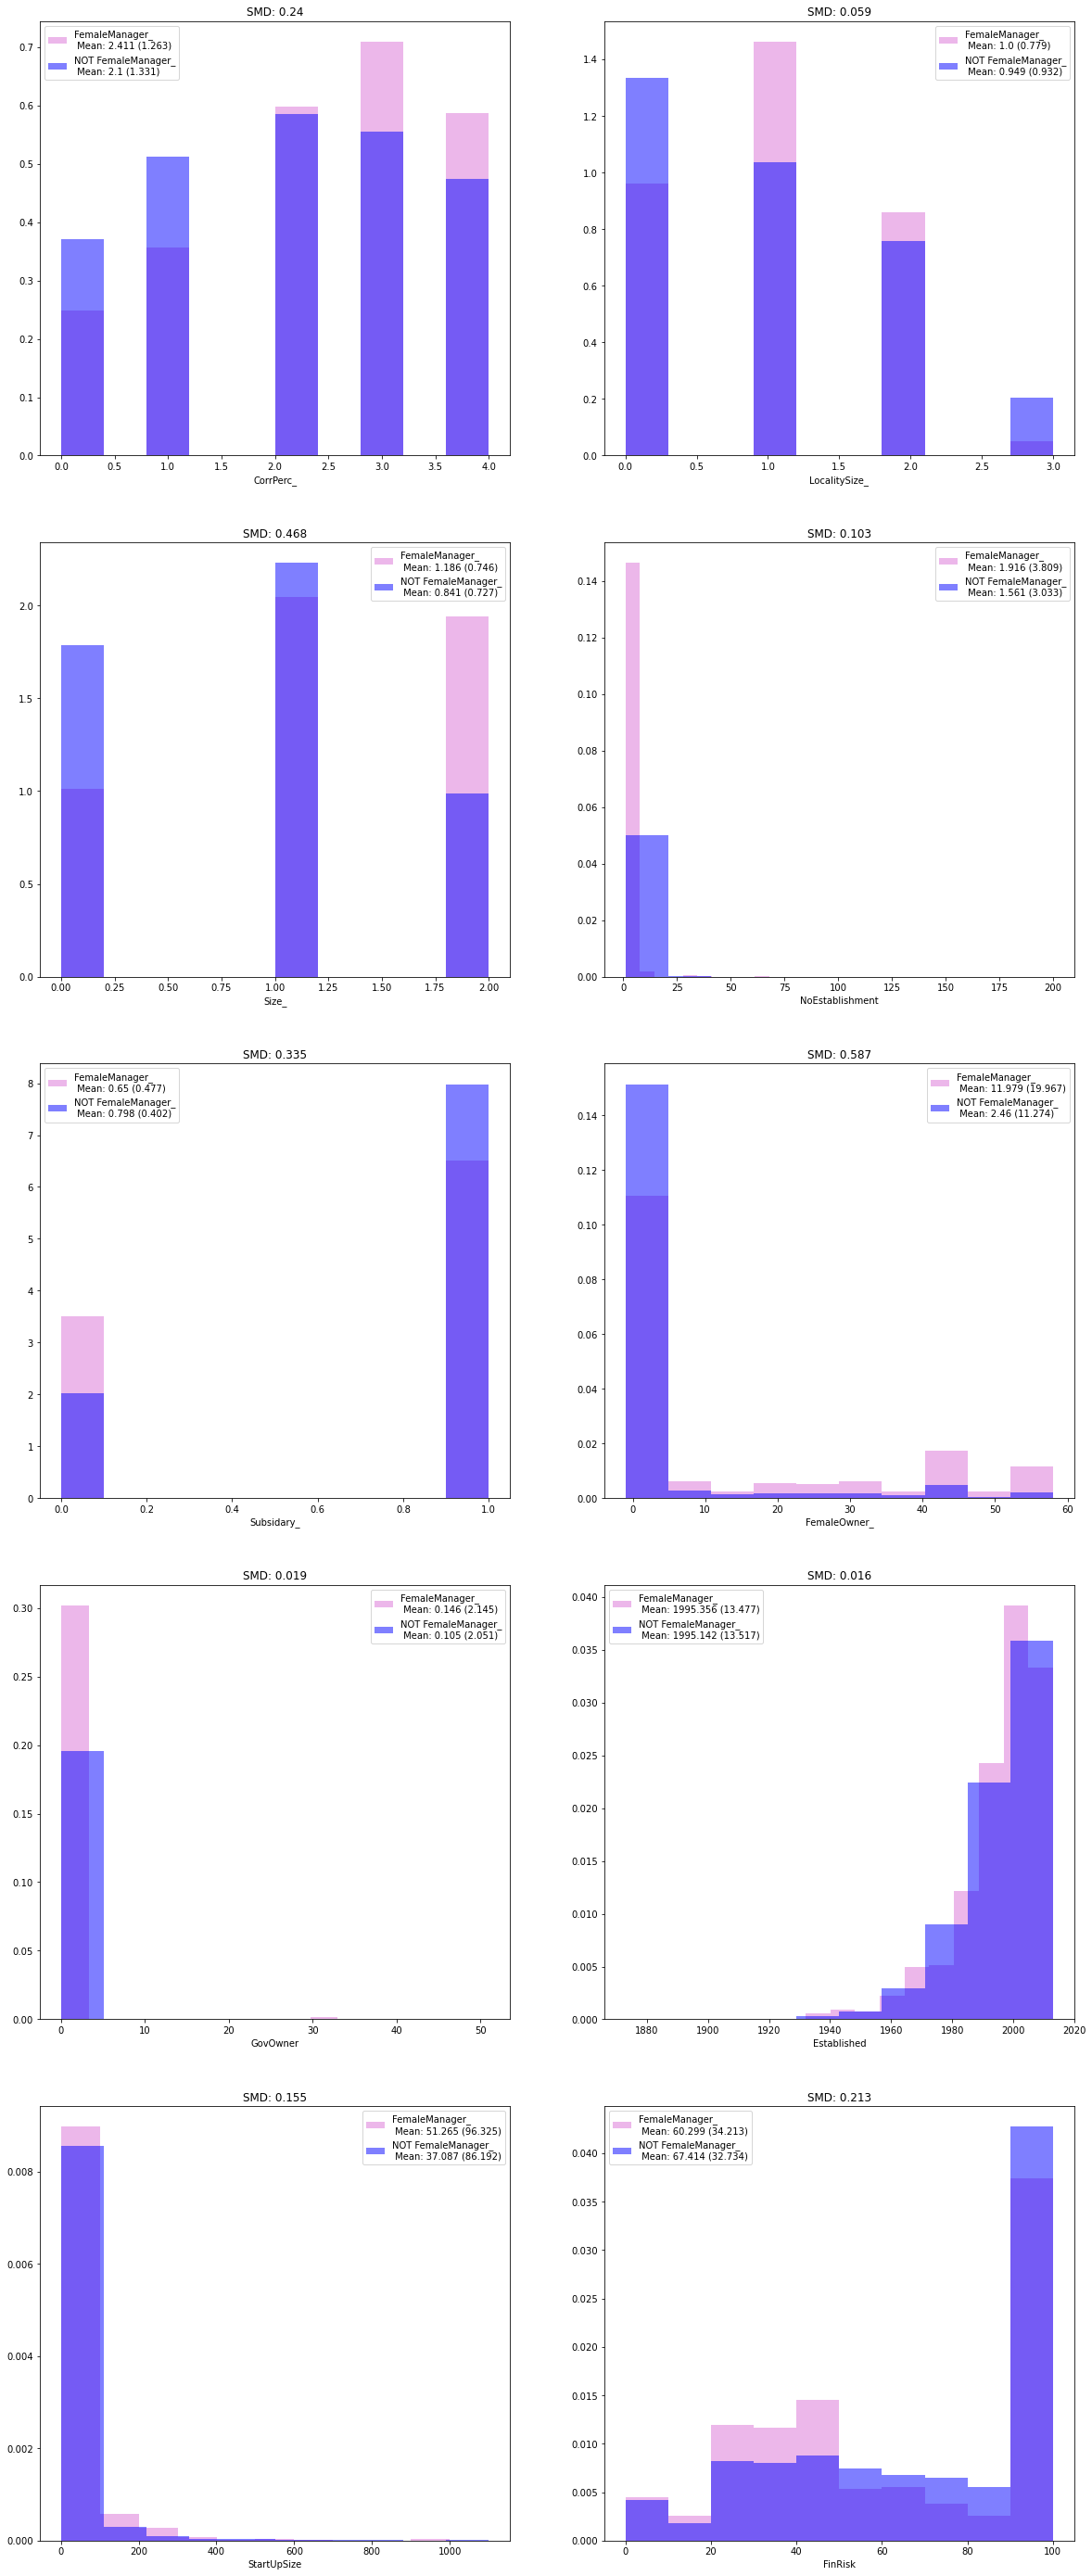

In [16]:
## Comparing Treatment and Control Groups
def compare_treat_control(df, covariates, rows, cols,  treat_var = "FemaleManager_", plotting = True):

    """
    funct: comapre_treat_control
    Compares the balance between variables in the treatment and control variable.

    Inputs:
    - df:             Dataframe containing all data
    - covariates:     List variables on which to check balance
    - rows, cols:     no of rows and columns in the subplot grid
    - treat_var:      variable by which to group
    - plotting = True:Wether to plot the histograms

    Output: 
    - Histograms of the distributions on the covariates
    - smd:             A list of the absolute squared mean difference 
    """

    if plotting:
        if len(covariates) >1:

            plt.subplots(rows, cols, figsize = (cols *10, rows*10))

    smds = []

    for n, variable in enumerate(covariates):

        treated = df[df[treat_var] == 1][variable].values
        control = df[df[treat_var] == 0][variable].values

        #get means
        mean_t = np.mean(treated)
        mean_c = np.mean(control)

        #get sd
        sd_t = np.std(treated)
        sd_c = np.std(control)

        #square mean difference
        smd = abs(mean_t - mean_c) / np.sqrt((sd_t ** 2 + sd_c ** 2) / 2)

        smds.append(smd)

        if plotting:
            #plot a histogram
            if len(covariates) >1:
                plt.subplot(rows, cols, n +1)
            plt.hist(treated, alpha = .5, color = 'orchid',density= True, label = f"{treat_var}\n Mean: {round(mean_t, 3)} ({round(sd_t, 3)})")
            plt.hist(control, alpha = .5, color = "blue", density= True, label = f"NOT {treat_var}\n Mean: {round(mean_c, 3)} ({round(sd_c, 3)})")
            plt.xlabel(variable)
            plt.title(f"SMD: {round(smd, 3)}")
            plt.legend()

    return smds

smds_prematch = compare_treat_control(matching_data, ["CorrPerc_",'LocalitySize_', 
            'Size_',
            'NoEstablishment', 
            'Subsidary_', 
            'FemaleOwner_', 
            'GovOwner',
            'Established', 
            'StartUpSize', 
            'FinRisk'], 5,2)


Text(0, 0.5, 'SMD')

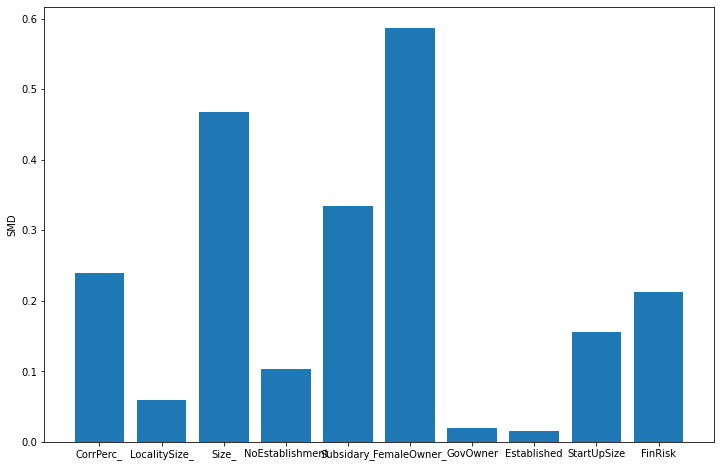

In [17]:
plt.figure(figsize = (12,8))
plt.bar(["CorrPerc_",'LocalitySize_', 
            'Size_',
            'NoEstablishment', 
            'Subsidary_', 
            'FemaleOwner_', 
            'GovOwner',
            'Established', 
            'StartUpSize', 
            'FinRisk'],smds_prematch)
plt.ylabel("SMD")

## Estimate Logistic Regression

In [18]:
#set up the logistic regression
#note how the outcome variable is FemaleManager_ -> the treatment
logistic = LogisticRegression()
logistic.fit(y = X_train.iloc[:,0], 
            X = X_train.iloc[:,1:])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
predicted_logit = logistic.predict_proba(
            X = X_test.iloc[:,1:])

#Get the score
logistic.score(y = X_test.iloc[:, 0], X = X_test.iloc[:,1:])

0.9183914843287996

In [20]:
#coefficients 

tabl = pd.DataFrame(['LocalitySize_', 'Size_', 'NoEstablishment', 'Subsidary_',
       'FemaleOwner_', 'GovOwner', 'Established', 'StartUpSize', 'FinRisk',
       'Industry_0', 'Industry_1', 'Industry_2', 'Industry_3', 'Industry_4',
       'Industry_5', 'Industry_6', 'Industry_7', 'Industry_8', 'Industry_9',
       'Industry_10', 'Industry_11', 'Industry_12', 'Industry_13',
       'Industry_14', 'Industry_15', 'Industry_16', 'Industry_17',
       'Industry_18', 'Industry_19', 'Industry_20', 'Industry_21',
       'Industry_22', 'Industry_23', 'Industry_24', 'Industry_25',
       'Industry_26', 'Region_0', 'Region_1', 'Region_2', 'Region_3',
       'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9',
       'Region_10', 'Region_11', 'Region_12', 'Region_13', 'Region_14',
       'Region_15', 'Region_16', 'Region_17', 'Region_18', 'Region_19',
       'Region_20', 'Region_21', 'Region_22', 'LegalStatus_0', 'LegalStatus_1',
       'LegalStatus_2', 'LegalStatus_3', 'LegalStatus_4', 'LegalStatus_5'])
tabl['Coefs'] = logistic.coef_[0]

In [21]:
joined_test = X_test.copy()
joined_test['ps_logistic'] = predicted_logit[:,1]

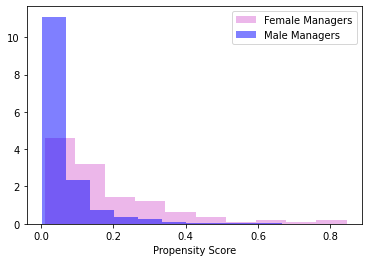

In [22]:
plt.hist(joined_test[joined_test["FemaleManager_"] == 1]['ps_logistic'], alpha = .5, color = 'orchid',density= True, label = "Female Managers")
plt.hist(joined_test[joined_test["FemaleManager_"] == 0]['ps_logistic'], alpha = .5, color = "blue", density= True, label = "Male Managers")
plt.xlabel("Propensity Score")
plt.legend()

In [23]:
## get prettier printed model 

#### ! The results from this are slightly different to the sklearn predicted probabilities. 
## I use them only for reporting. The difference is ignorable.
import statsmodels.api as sm
import statsmodels.formula.api as smf
logit_model=sm.Logit(X_train.iloc[:,0], 
            X_train.iloc[:,1:])
result=logit_model.fit()

log_table = Stargazer([result])
log_table.covariate_order(['LocalitySize_', 'Size_', 'NoEstablishment', 'Subsidary_',
       'FemaleOwner_', 'GovOwner', 'Established', 'StartUpSize', 'FinRisk',
       'Industry_0', 'Industry_1', 'Industry_2', 'Industry_3', 'Industry_4',
       'Industry_5', 'Industry_6', 'Industry_7', 'Industry_8', 'Industry_9',
       'Industry_10', 'Industry_11', 'Industry_12', 'Industry_13',
       'Industry_14', 'Industry_15', 'Industry_16', 'Industry_17',
       'Industry_18', 'Industry_19', 'Industry_20', 'Industry_21',
       'Industry_22', 'Industry_23', 'Industry_24', 'Industry_25',
       'Industry_26', 'Region_0', 'Region_1', 'Region_2', 'Region_3',
       'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9',
       'Region_10', 'Region_11', 'Region_12', 'Region_13', 'Region_14',
       'Region_15', 'Region_16', 'Region_17', 'Region_18', 'Region_19',
       'Region_20', 'Region_21', 'Region_22', 'LegalStatus_0', 'LegalStatus_1',
       'LegalStatus_2', 'LegalStatus_3', 'LegalStatus_4', 'LegalStatus_5'])

         Current function value: 0.216490
         Iterations: 35
/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [24]:
log_table

## Estimate Neural Network 

In [25]:
from keras.models import Sequential
from keras.layers import Dense

In [26]:
#build neural network

model = Sequential()
model.add(Dense(25, input_dim= 65, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model.fit(X_train.iloc[:,1:], X_train.iloc[:,0], 
            epochs=150, 
            validation_split=0.33, 
            batch_size=150, 
            verbose = 0)

# evaluate the keras model
_, accuracy = model.evaluate(y = X_train.iloc[:,0], 
            x = X_train.iloc[:,1:])
print('Accuracy: %.2f' % (accuracy*100))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

6760/6760 [==============================] - 0s 10us/step
Accuracy: 92.57


In [27]:
joined_test['ps_nn'] = model.predict_proba(X_test.iloc[:,1:])

## Weighted NN

In [28]:
## calculate the weights for each class

#we scale by half the length of the training set as this maintains the loss magnitude (TensorFlow, nd.)
weight_0 = float(1/(len(X_train.iloc[:,0]) - np.sum(X_train.iloc[:,0])) * 0.5*(len(X_train.iloc[:,0])))
print("Weight control:", weight_0)

weight_1 = float(1/np.sum(X_train.iloc[:,0]) * 0.5*(len(X_train.iloc[:,0])))
print("Weight treatment:",weight_1)

Weight control: 0.541406375140157
Weight treatment: 6.537717601547389


In [29]:
#use same architecture as unweighted NN 

model_w = Sequential()
model_w.add(Dense(25, input_dim= 65, activation='relu'))
model_w.add(Dense(8, activation='relu'))
model_w.add(Dense(1, activation='sigmoid'))

model_w.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit the keras model on the dataset
model_w.fit(X_train.iloc[:,1:], X_train.iloc[:,0], 
            epochs=150, 
            validation_split=0.33, 
            batch_size=150, 
            verbose = 0, 
            class_weight = {0: weight_0, 1: weight_1})

# evaluate the keras model
_, accuracy = model_w.evaluate(y = X_train.iloc[:,0], 
            x = X_train.iloc[:,1:])
print('Accuracy: %.2f' % (accuracy*100))

joined_test['ps_nn_w'] = model_w.predict_proba(X_test.iloc[:,1:])

6760/6760 [==============================] - 0s 10us/step
Accuracy: 69.85


### Compare Models

Text(0.0, -0.1, 'Panel C: Weighted NN')

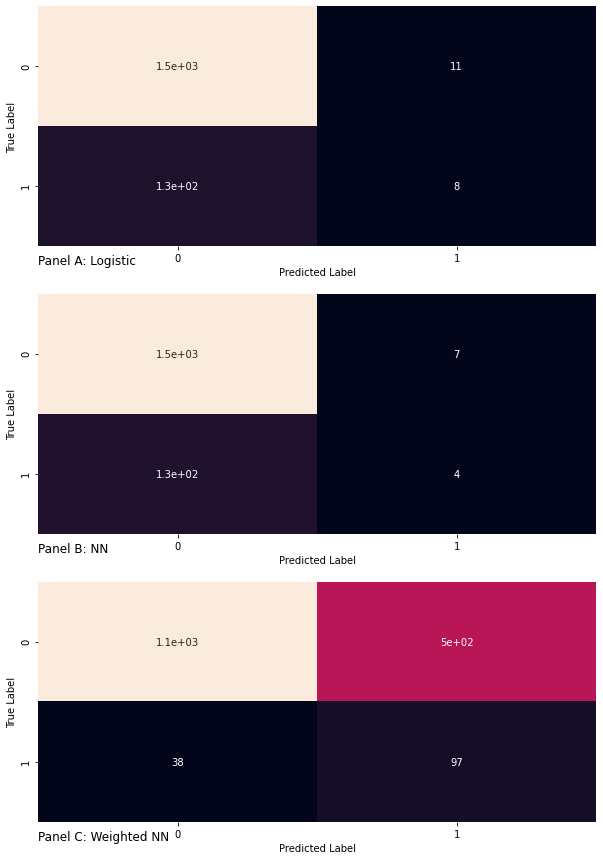

In [30]:
plt.figure(figsize=(10,15))
# Plot confusion matrix
plt.subplot(3,1,1)
sns.heatmap(confusion_matrix(joined_test['FemaleManager_'], joined_test['ps_logistic'] >.5), annot=True,cbar=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Panel A: Logistic", loc = 'left', y = -.1)

# Plot confusion matrix
plt.subplot(3,1,2)
sns.heatmap(confusion_matrix(joined_test['FemaleManager_'], joined_test['ps_nn'] >.5), annot=True,cbar=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Panel B: NN", loc = 'left', y = -.1)

# Plot confusion matrix
plt.subplot(3,1,3)
sns.heatmap(confusion_matrix(joined_test['FemaleManager_'], joined_test['ps_nn_w'] >.5), annot=True,cbar=False)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title("Panel C: Weighted NN", loc = 'left', y = -.1)

[0.8451774445951158, 0.7138401721807462, 1.041414811122182]

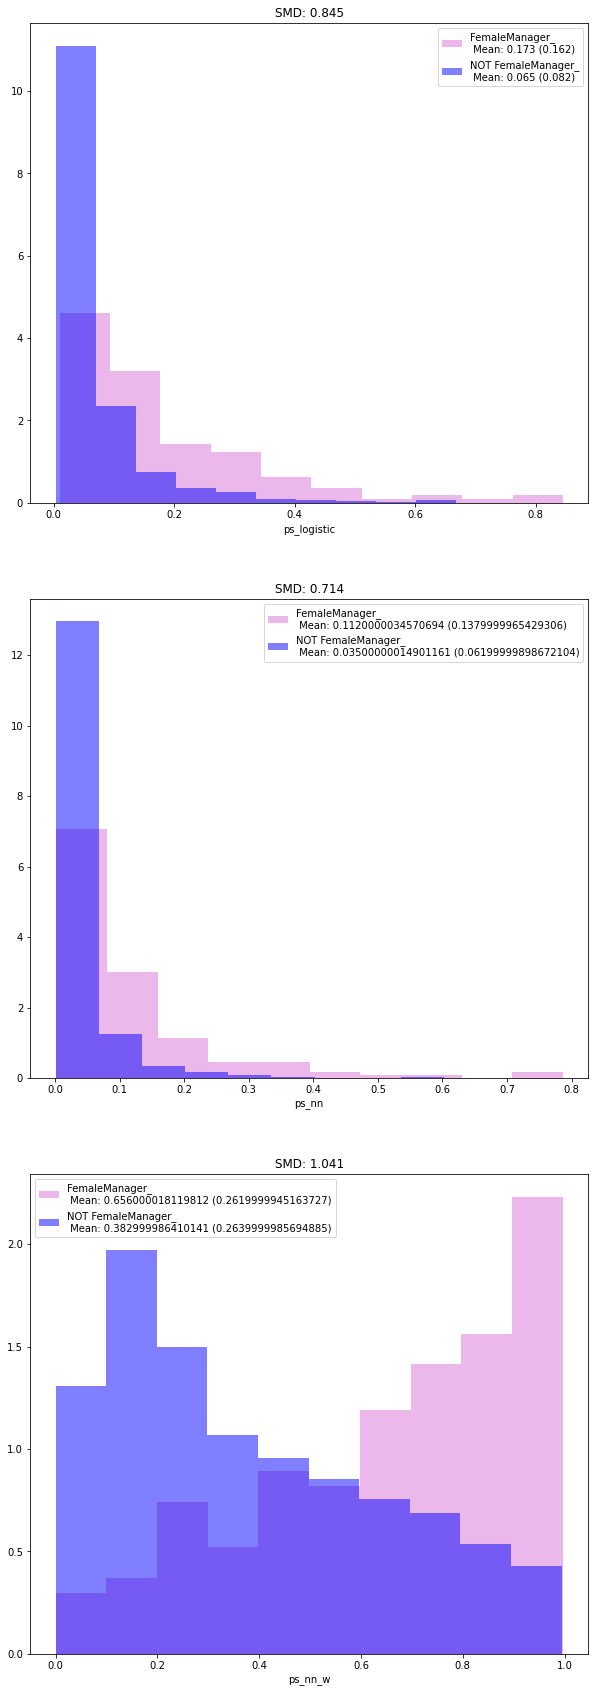

In [31]:
compare_treat_control(joined_test, ['ps_logistic','ps_nn','ps_nn_w'], 3, 1)

## Get some shap values

In [32]:
import shap

In [33]:
e_nn = shap.DeepExplainer(model, X_train.iloc[:,1:])

In [34]:
shap_values_nn = e_nn.shap_values(X_train.iloc[:,1:].values)

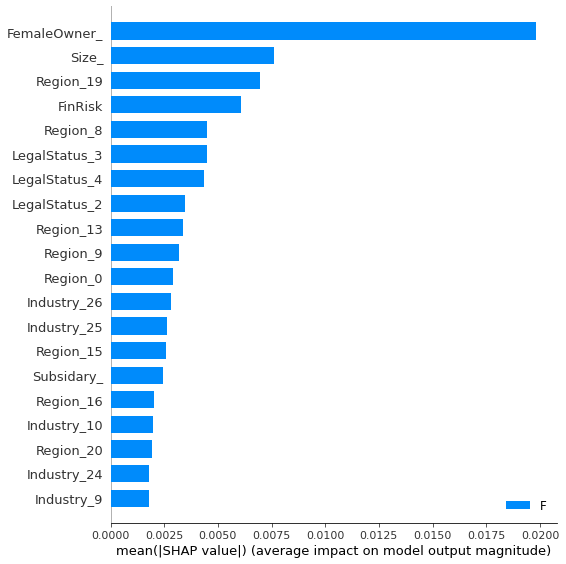

In [35]:
shap.summary_plot(shap_values_nn, X_test.iloc[:,1:], plot_type="bar", class_names="F")

In [36]:
## for weighted

e_nn_w = shap.DeepExplainer(model_w, X_train.iloc[:,1:])
shap_values_nn_w = e_nn_w.shap_values(X_train.iloc[:,1:].values)

In [37]:
np.asarray(shap_values_nn).shape

(1, 6760, 65)

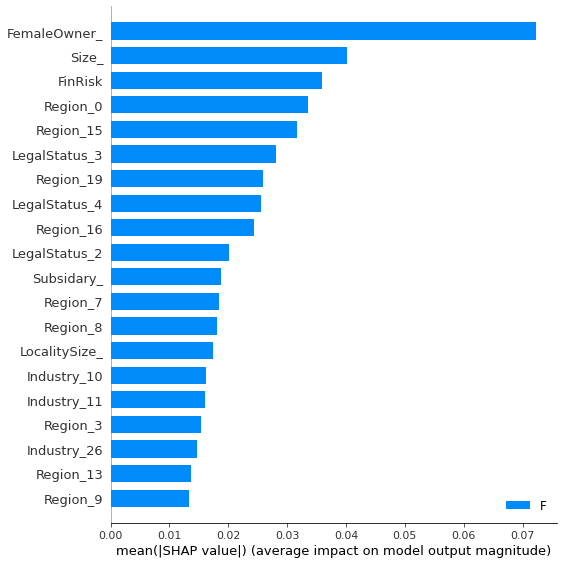

In [38]:
shap.summary_plot(shap_values_nn_w, X_test.iloc[:,1:], plot_type="bar", class_names="Female")

# Matching

In [39]:
#compile dataframes back together

matching_data['ps_logistic'] = logistic.predict_proba(X = matching_data.iloc[:,2:])[:,1]
matching_data['ps_nn'] = model.predict_proba(matching_data.iloc[:,2:-1])
matching_data['ps_nn_w'] = model_w.predict_proba(matching_data.iloc[:,2:-2])

[0.9948786628325287, 0.8672256319745874, 1.2475362042248257]

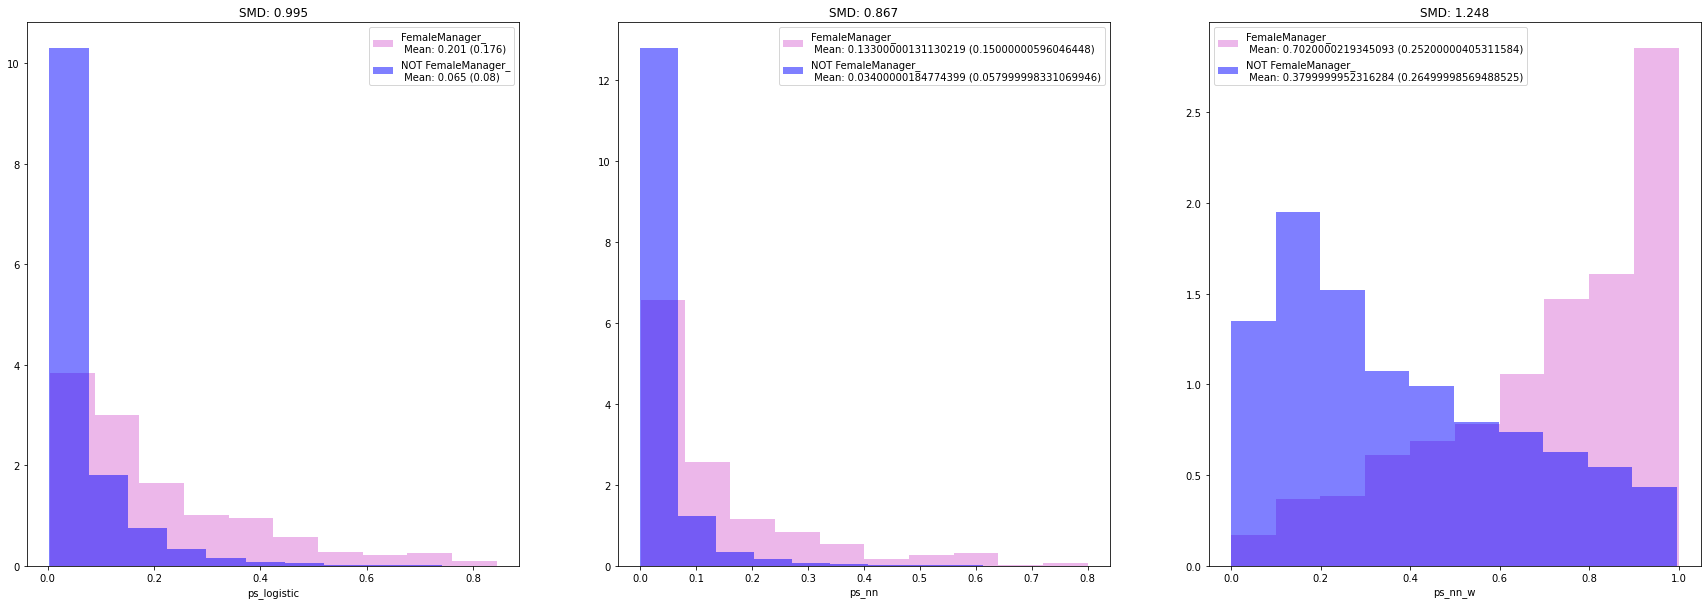

In [40]:
compare_treat_control(matching_data, ['ps_logistic','ps_nn','ps_nn_w'], 1,3)

### Importing pyr 

In [41]:
import rpy2
from rpy2.robjects.packages import importr
# import R's "base" package
base = importr('base')

# import R's "utils" package
utils = importr('utils')

In [42]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

from rpy2.robjects.conversion import localconverter

matching_r = importr('Matching')


In [43]:
with localconverter(ro.default_converter + pandas2ri.converter):
  df_matching_R = ro.conversion.py2rpy(matching_data.astype('float64'))

In [44]:
## get the inputs for matching in R compatible vectors

outcome_r = ro.FloatVector(matching_data['CorrPerc_'])
treat_r = ro.FloatVector(matching_data['FemaleManager_'])
ps_log_r = ro.FloatVector(matching_data['ps_logistic'])
ps_nn_r = ro.FloatVector(matching_data['ps_nn'])
ps_nn_w_r = ro.FloatVector(matching_data['ps_nn_w'])

r_Match = ro.r["Match"]

matched_outputs_logistic = r_Match(Y = outcome_r, 
                        Tr = treat_r, 
                        X = ps_log_r,  
                        estimand = "ATT", 
                        caliper = .2, 
                        replace=True, 
                        M = 1,
                        ties = False
                        )


matched_outputs_nn = r_Match(Y = outcome_r, 
                        Tr = treat_r, 
                        X = ps_nn_r,  
                        estimand = "ATT", 
                        caliper = .2, 
                        replace=True, 
                        M = 1,
                        ties = False
                        )

matched_outputs_nn_w = r_Match(Y = outcome_r, 
                        Tr = treat_r, 
                        X = ps_nn_w_r,  
                        estimand = "ATT", 
                        caliper = .2, 
                        replace=True, 
                        M = 1,
                        ties = False
                        )

In [45]:
print("Logistic PS matching dropped treatment obs:", matched_outputs_logistic.rx2('ndrops')[0])
print("NeuralNet PS matching dropped treatment obs:", matched_outputs_nn.rx2('ndrops')[0])
print("NeuralNet with weighting PS matching dropped treatment obs:", matched_outputs_nn_w.rx2('ndrops')[0])

Logistic PS matching dropped treatment obs: 5.0
NeuralNet PS matching dropped treatment obs: 5.0
NeuralNet with weighting PS matching dropped treatment obs: 0.0


In [61]:
## Logistic

treated_index_log = np.asarray(matched_outputs_logistic.rx2('index.treated'))
control_index_log = np.asarray(matched_outputs_logistic.rx2('index.control'))
matched_index_log = (np.asarray([treated_index_log, control_index_log])-1).flatten()
matched_index_log

matched_logistic = matching_data.iloc[np.asarray(matched_index_log),:]

## Evaluate matched observations

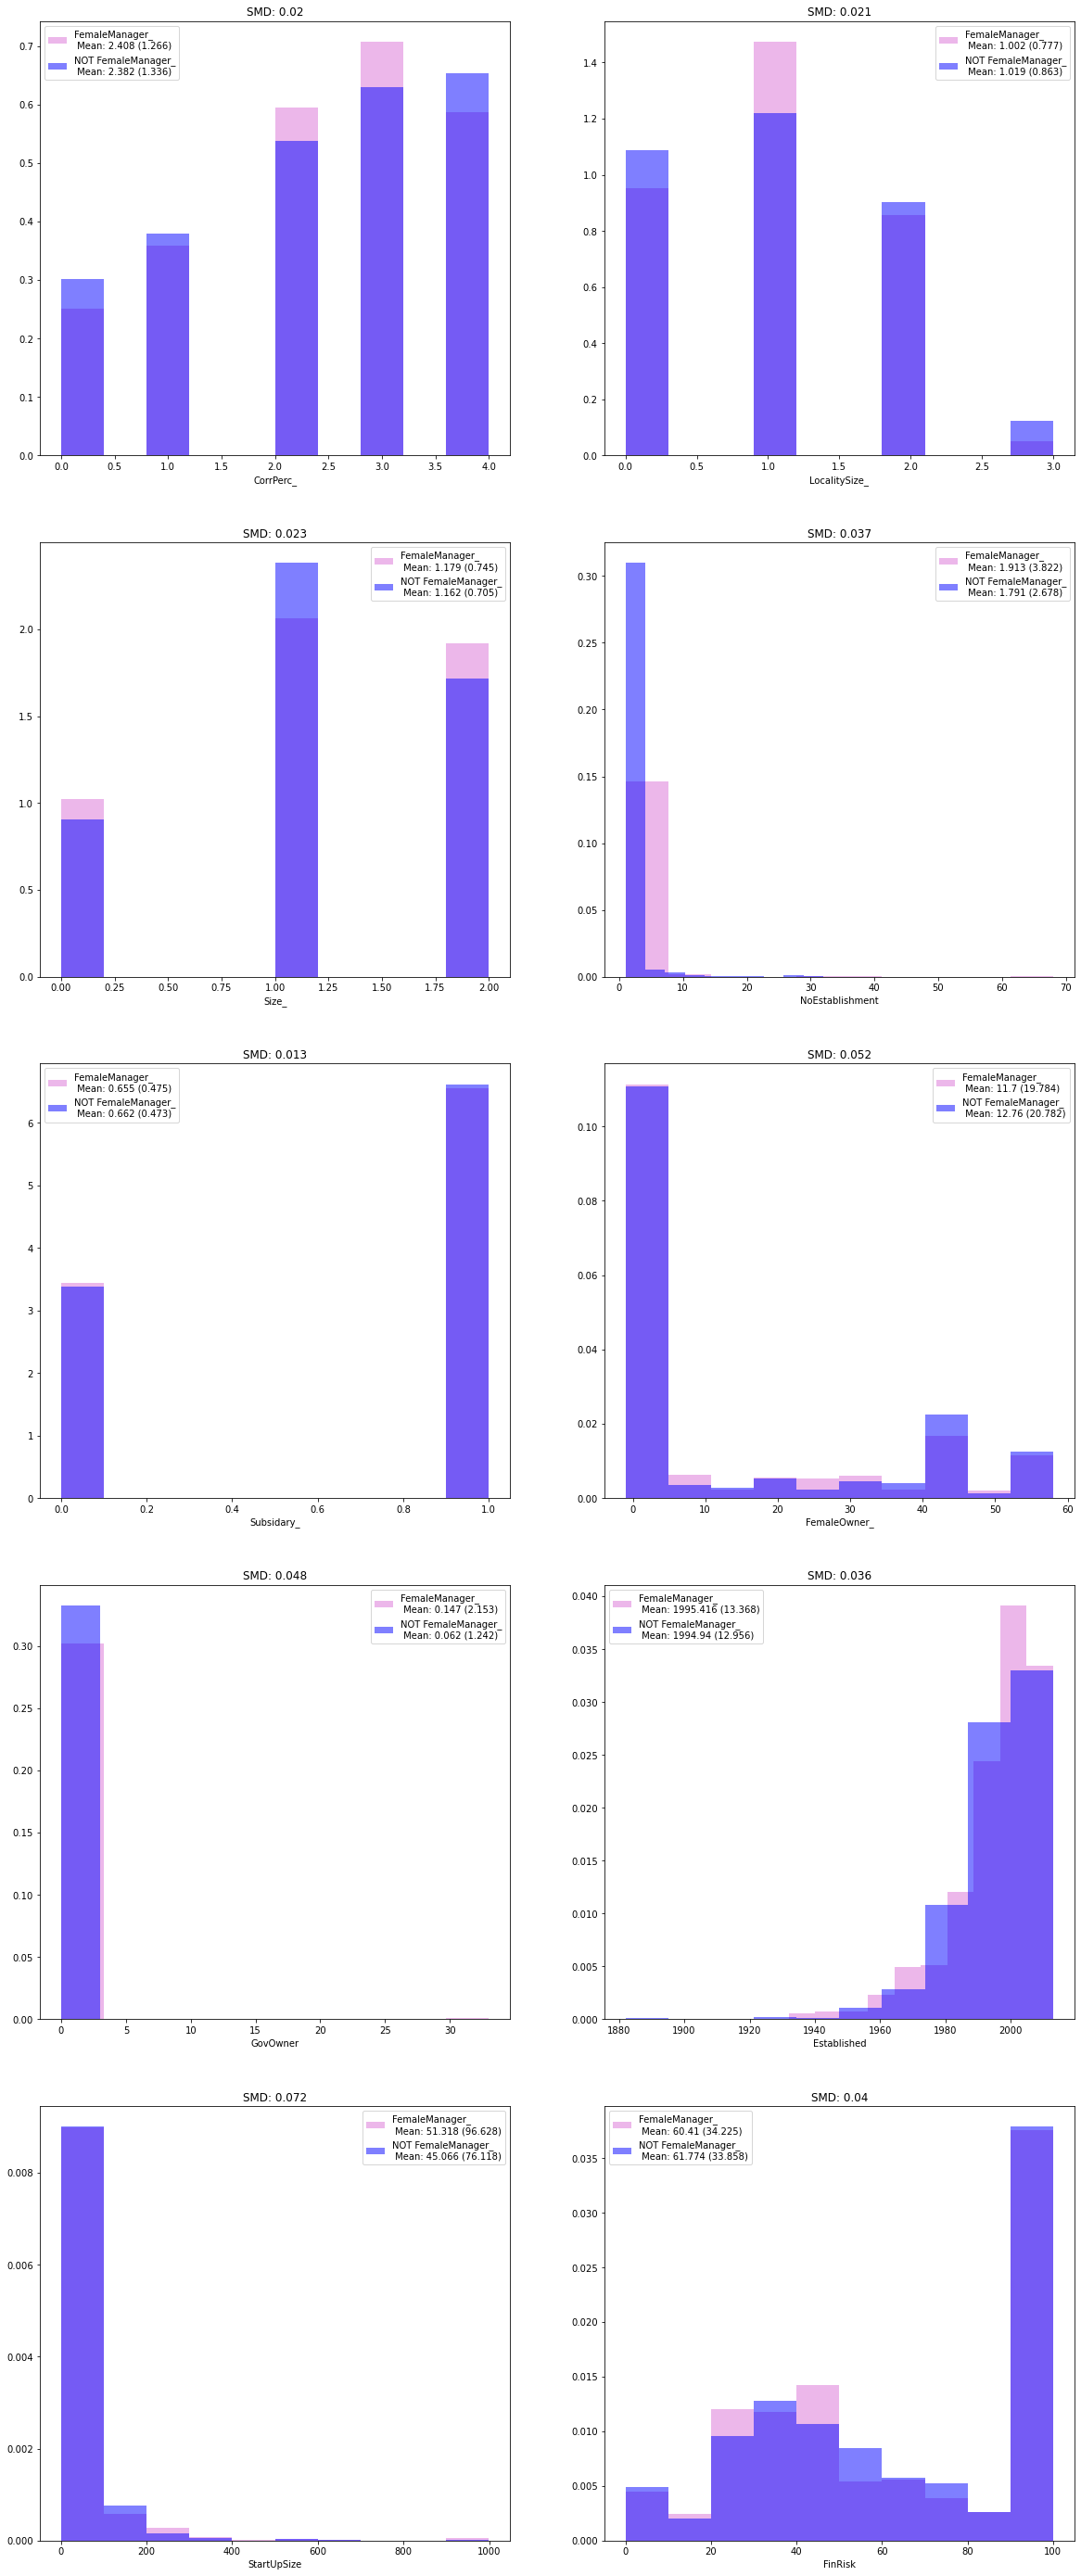

In [62]:
#compare balance with the matched data
smds_log_match = compare_treat_control(matched_logistic,["CorrPerc_",'LocalitySize_', 
            'Size_',
            'NoEstablishment', 
            'Subsidary_', 
            'FemaleOwner_', 
            'GovOwner',
            'Established', 
            'StartUpSize', 
            'FinRisk'], 5, 2)

In [63]:
treated_index_log

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  15.,  16.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
        58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
        69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.,
       102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
       113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123.,
       124., 125., 126., 128., 129., 130., 131., 132., 133., 134., 135.,
       136., 137., 138., 139., 140., 141., 142., 143., 144., 145., 146.,
       147., 148., 149., 150., 151., 152., 153., 15

In [64]:
## NN

treated_index_nn = np.asarray(matched_outputs_nn.rx2('index.treated'))
control_index_nn = np.asarray(matched_outputs_nn.rx2('index.control'))
matched_index_nn = (np.asarray([treated_index_nn, control_index_nn]) -1).flatten()
matched_index_nn

matched_nn = matching_data.iloc[np.asarray(matched_index_nn),:]

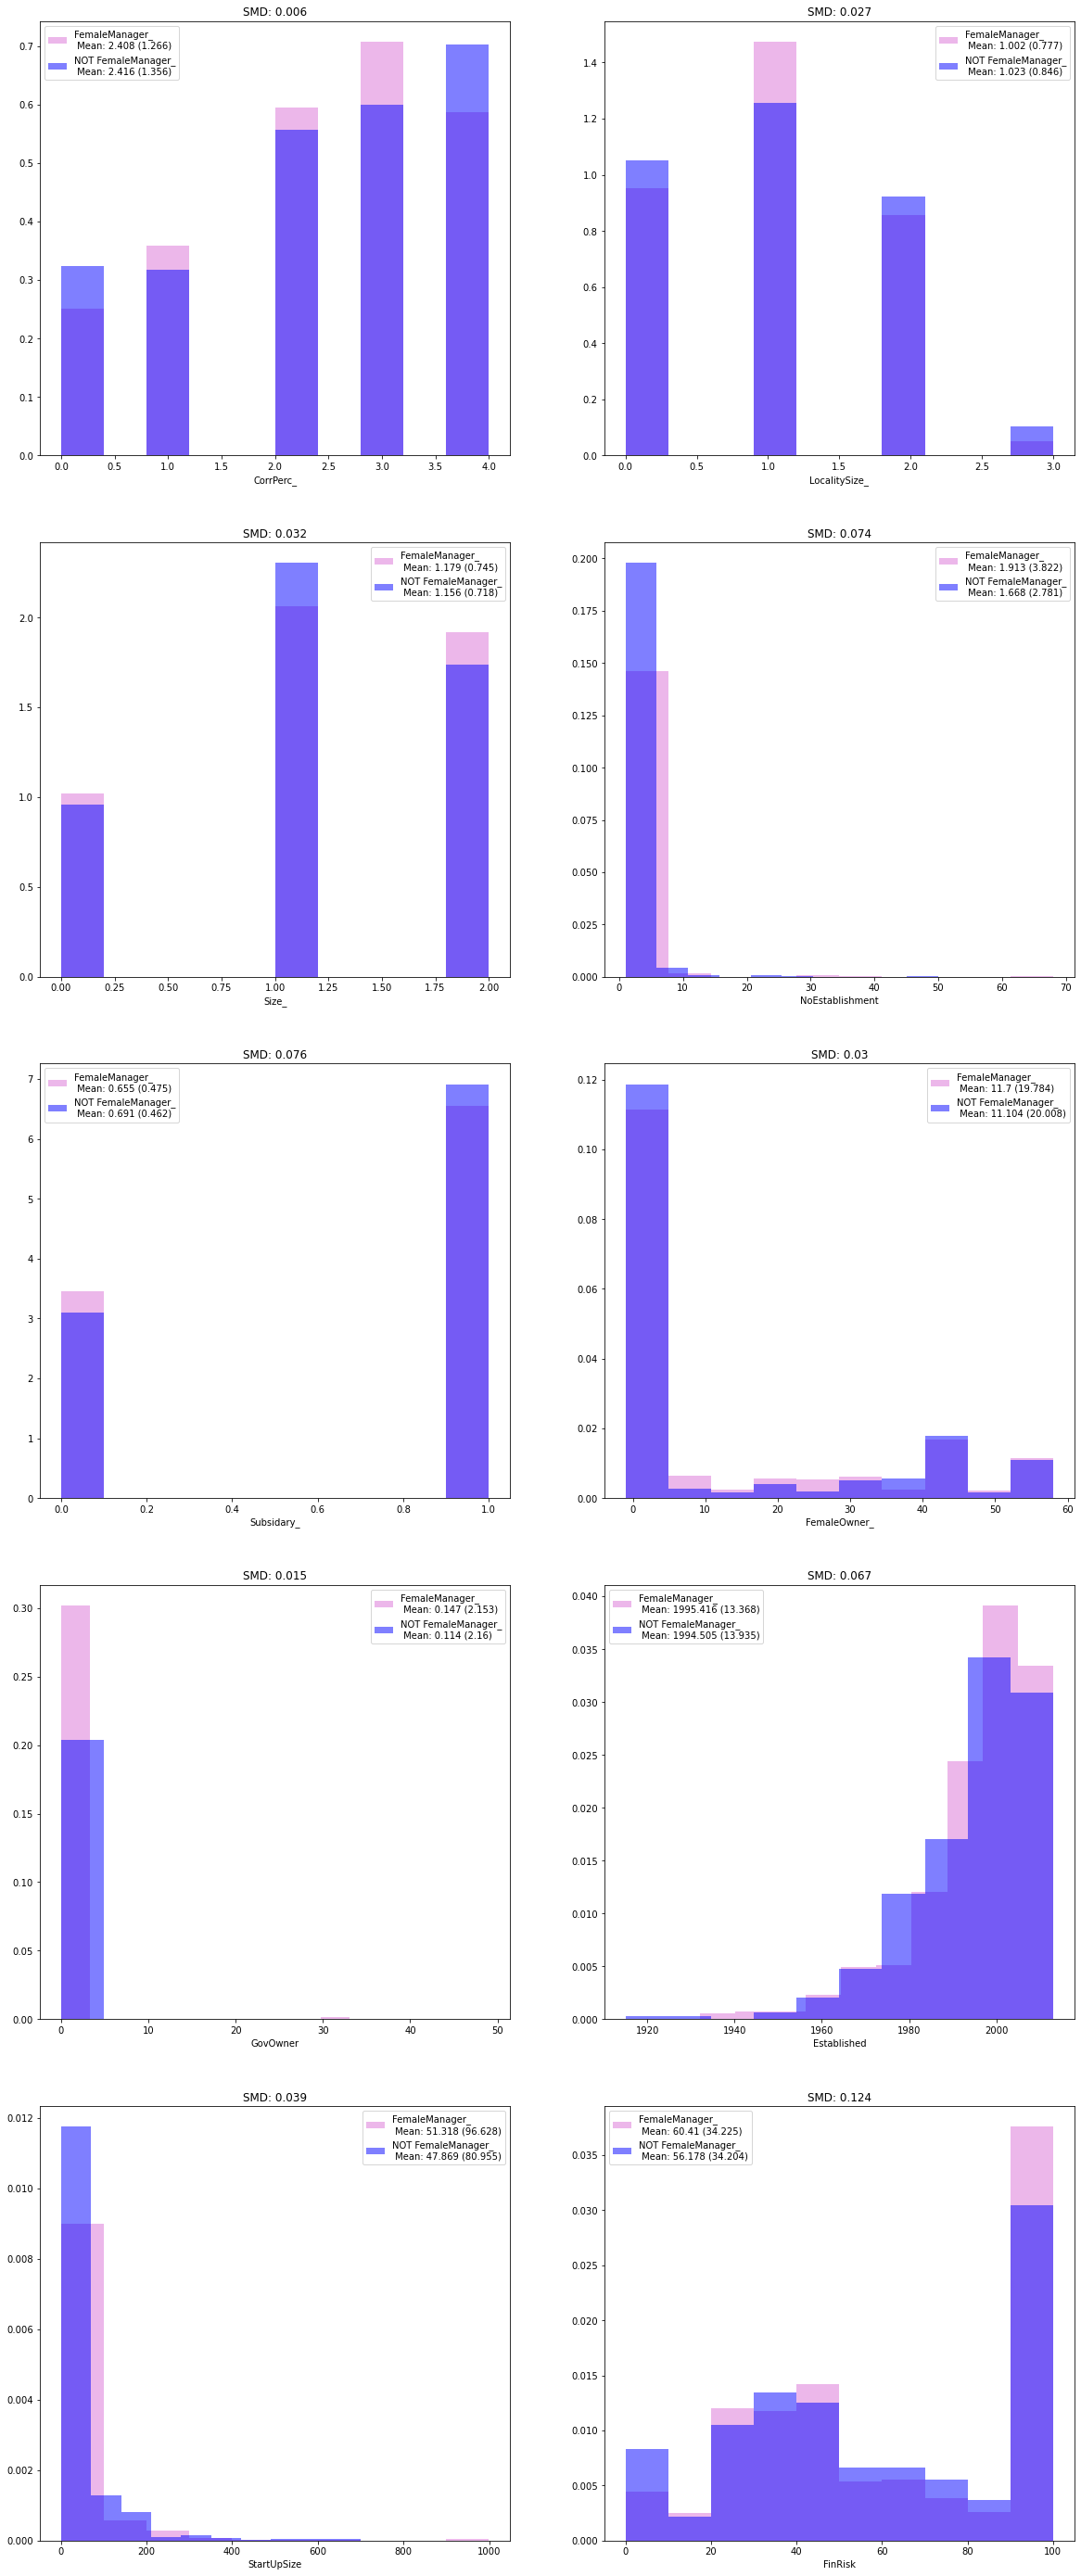

In [65]:
smds_nn_match = compare_treat_control(matched_nn,["CorrPerc_",'LocalitySize_', 
            'Size_',
            'NoEstablishment', 
            'Subsidary_', 
            'FemaleOwner_', 
            'GovOwner',
            'Established', 
            'StartUpSize', 
            'FinRisk'], 5, 2)

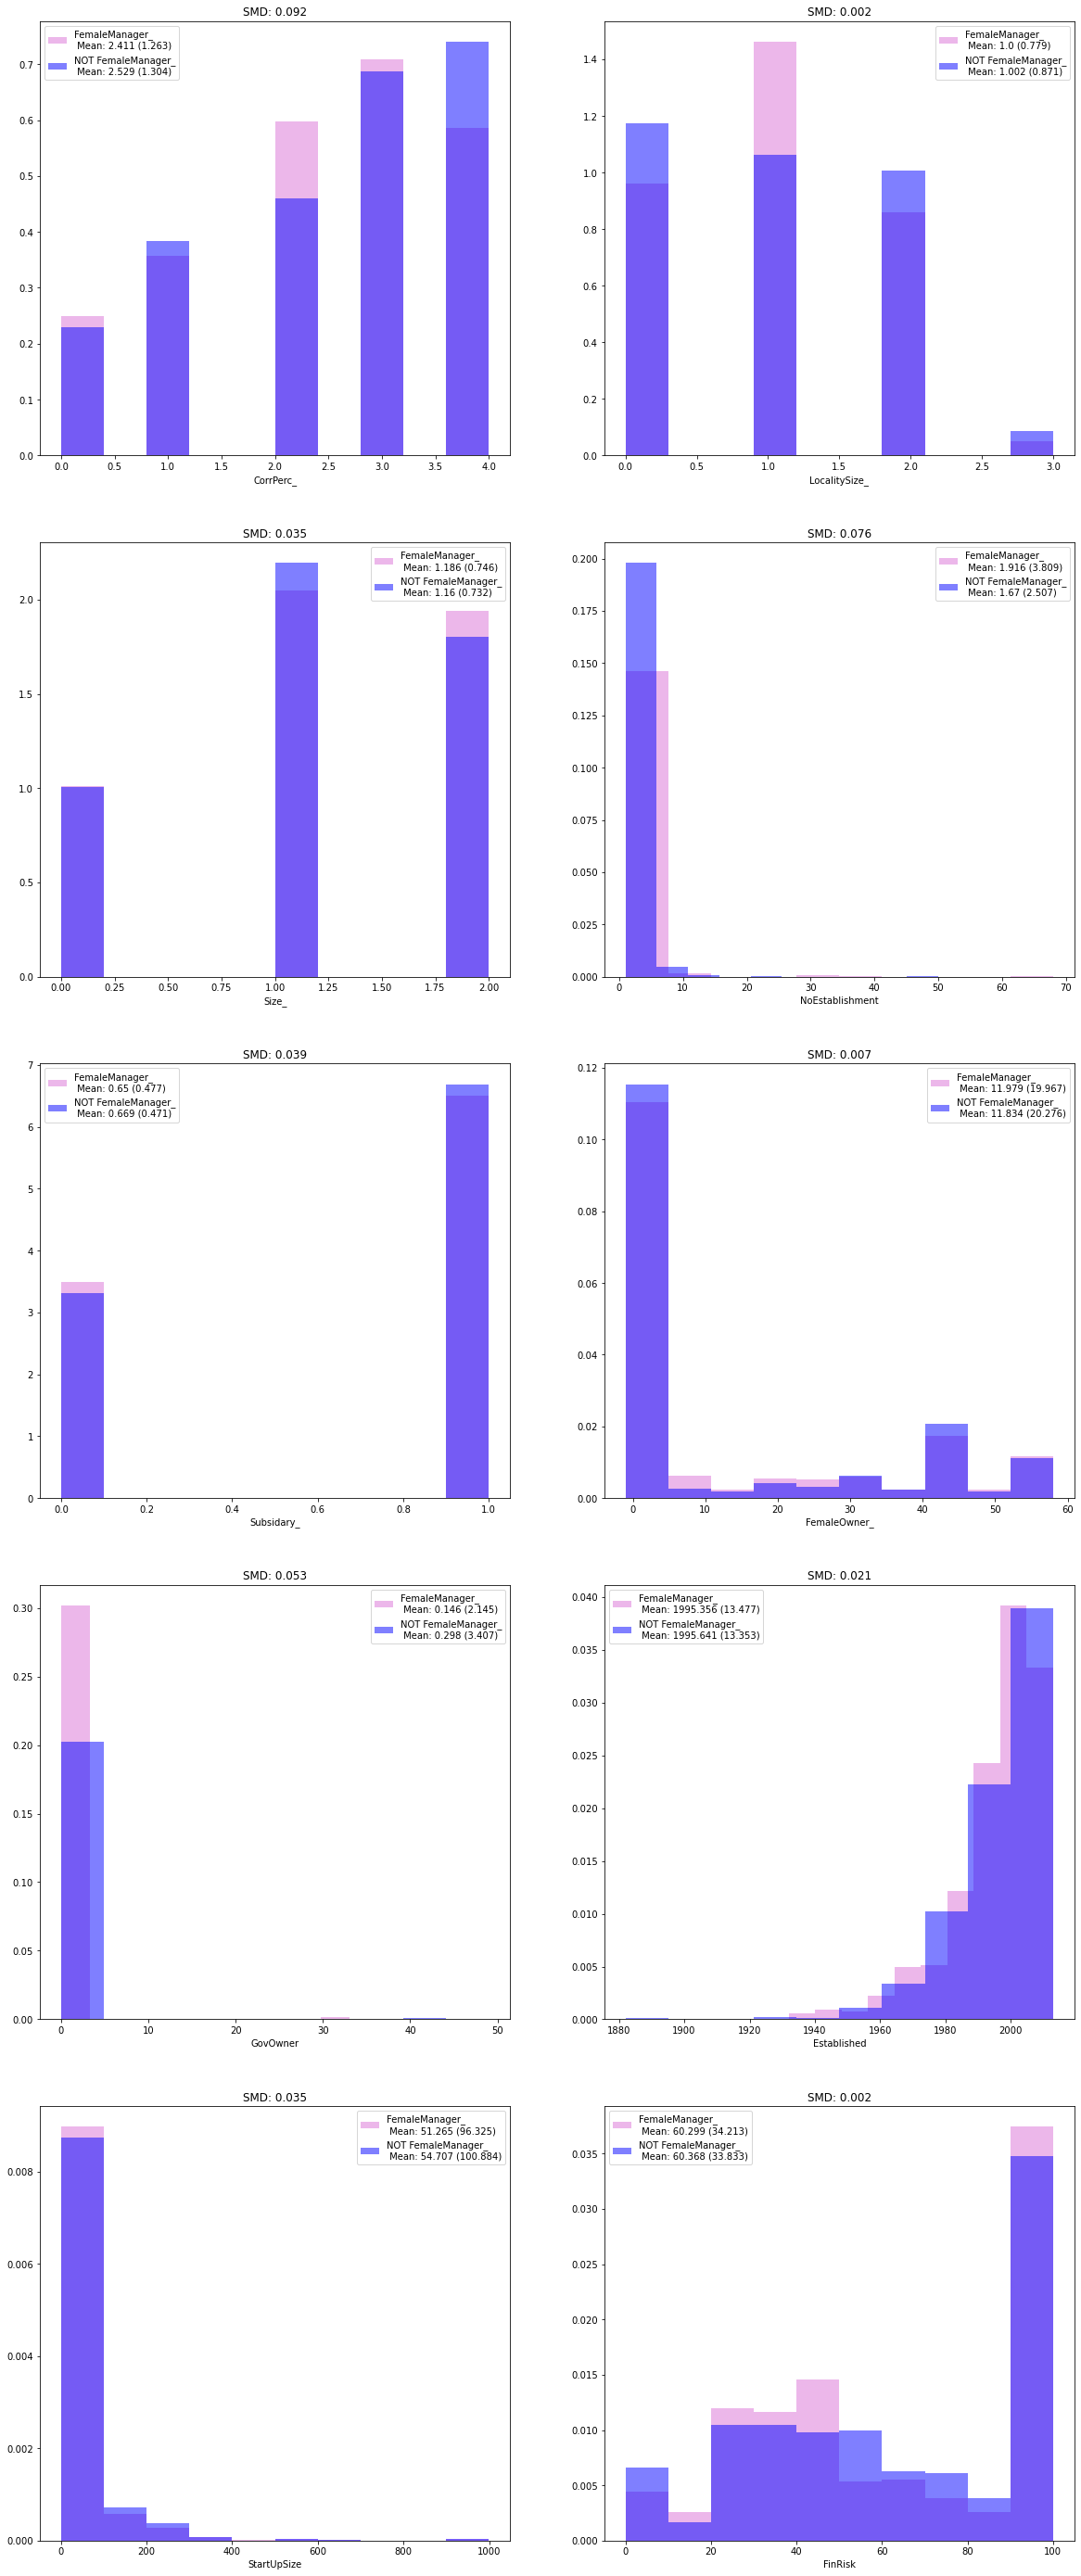

In [66]:
## NN

treated_index_nn_w = np.asarray(matched_outputs_nn_w.rx2('index.treated'))
control_index_nn_w = np.asarray(matched_outputs_nn_w.rx2('index.control'))
matched_index_nn_w = (np.asarray([treated_index_nn_w, control_index_nn_w]) -1).flatten()
matched_index_nn_w

matched_nn_w = matching_data.iloc[np.asarray(matched_index_nn_w),:]

smds_nn_match_w = compare_treat_control(matched_nn_w,["CorrPerc_",'LocalitySize_', 
            'Size_',
            'NoEstablishment', 
            'Subsidary_', 
            'FemaleOwner_', 
            'GovOwner',
            'Established', 
            'StartUpSize', 
            'FinRisk'], 5, 2)

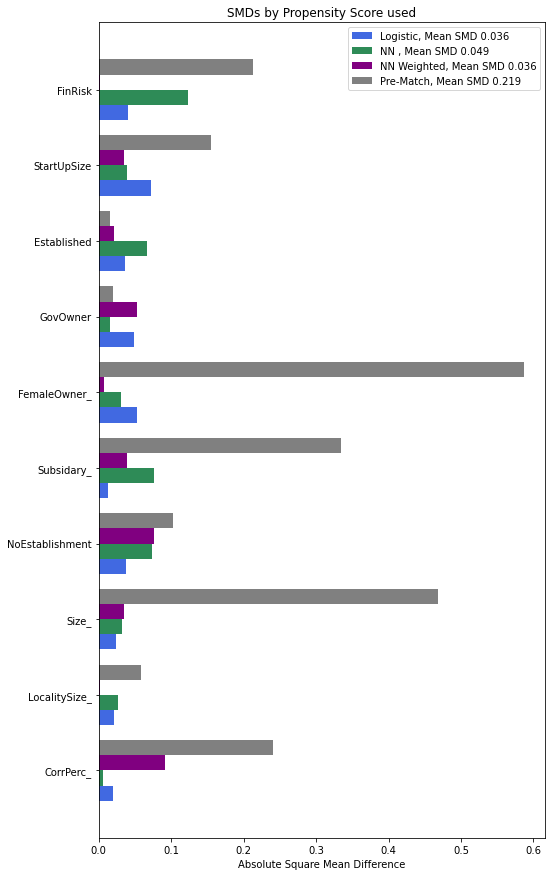

In [67]:
## Compare the SMDs of the different matched datasets

width = 0.2      # the width of the bars

variables = ["CorrPerc_",
            'LocalitySize_', 
            'Size_',
            'NoEstablishment', 
            'Subsidary_', 
            'FemaleOwner_', 
            'GovOwner',
            'Established', 
            'StartUpSize', 
            'FinRisk']


ind = np.arange(len(variables))

fig = plt.figure(figsize = (8,15))
ax = fig.add_subplot(111)
rects1 = ax.barh(ind, smds_log_match, width, color='royalblue')
rects2 = ax.barh(ind+width, smds_nn_match, width, color='seagreen')
rects3 = ax.barh(ind+width*2, smds_nn_match_w, width, color='purple')
rects4 = ax.barh(ind+width*3, smds_prematch, width, color='grey')

# add some
ax.set_xlabel('Absolute Square Mean Difference')
ax.set_title('SMDs by Propensity Score used')
ax.set_yticks(ind + 3*width / 2)
ax.set_yticklabels( variables )

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), (f'Logistic, Mean SMD {round(np.mean(smds_log_match), 3)}', f'NN , Mean SMD {round(np.mean(smds_nn_match),3)}',f'NN Weighted, Mean SMD {round(np.mean(smds_nn_match_w),3)}', f'Pre-Match, Mean SMD {round(np.mean(smds_prematch),3)}'))

plt.show()

## Calculate the Final OLS Model

In [68]:
mod_l = sm.OLS(matched_logistic.iloc[:,0], matched_logistic.iloc[:,1:-3])    # Describe model

res_l = mod_l.fit()       # Fit model

print(res_l.summary()) 

                            OLS Regression Results                            
Dep. Variable:              CorrPerc_   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     7.719
Date:                Sat, 19 Dec 2020   Prob (F-statistic):           1.81e-53
Time:                        08:03:54   Log-Likelihood:                -1964.4
No. Observations:                1294   AIC:                             4055.
Df Residuals:                    1231   BIC:                             4380.
Df Model:                          62                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
FemaleManager_      0.0245      0.064     

In [69]:
mod_nn = sm.OLS(matched_nn.iloc[:,0], matched_nn.iloc[:,1:-3])    # Describe model

res_nn = mod_nn.fit()       # Fit model

print(res_nn.summary())   # Summarize model
                           

                            OLS Regression Results                            
Dep. Variable:              CorrPerc_   R-squared:                       0.303
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     8.771
Date:                Sat, 19 Dec 2020   Prob (F-statistic):           1.51e-61
Time:                        08:03:54   Log-Likelihood:                -1953.6
No. Observations:                1294   AIC:                             4031.
Df Residuals:                    1232   BIC:                             4351.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
FemaleManager_      0.0145      0.064     

In [70]:
mod_nn_w = sm.OLS(matched_nn_w.iloc[:,0], matched_nn_w.iloc[:,1:-3])    # Describe model

res_nn_w = mod_nn_w.fit()       # Fit model

print(res_nn_w.summary())   # Summarize model

                            OLS Regression Results                            
Dep. Variable:              CorrPerc_   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     9.722
Date:                Sat, 19 Dec 2020   Prob (F-statistic):           2.10e-69
Time:                        08:03:54   Log-Likelihood:                -1922.7
No. Observations:                1304   AIC:                             3969.
Df Residuals:                    1242   BIC:                             4290.
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
FemaleManager_     -0.1030      0.062     

In [71]:
# Put all models into one table
comp_tables = Stargazer([res_l, res_nn,res_nn_w])


In [72]:

comp_tables

### Balance on indicator variables

In [73]:
indicators = ['Industry_0', 
            'Industry_1',
            'Industry_2', 
            'Industry_3', 
            'Industry_4', 
            'Industry_5', 
            'Industry_6',
            'Industry_7', 
            'Industry_8', 
            'Industry_9', 
            'Industry_10', 
            'Industry_11',
            'Industry_12', 
            'Industry_13', 
            'Industry_14',
            'Industry_15',
            'Industry_16', 
            'Industry_17', 
            'Industry_18', 
            'Industry_19',
            'Industry_20', 
            'Industry_21', 
            'Industry_22', 
            'Industry_23',
            'Industry_24', 
            'Industry_25', 
            'Industry_26', 
            'Region_0', 
            'Region_1',
            'Region_2', 
            'Region_3', 
            'Region_4', 
            'Region_5', 
            'Region_6', 
            'Region_7',
            'Region_8', 
            'Region_9', 
            'Region_10', 
            'Region_11', 
            'Region_12',
            'Region_13', 
            'Region_14', 
            'Region_15', 
            'Region_16', 
            'Region_17',
            'Region_18', 
            'Region_19', 
            'Region_20', 
            'Region_21', 
            'Region_22',
            'LegalStatus_0', 
            'LegalStatus_1', 
            'LegalStatus_2', 
            'LegalStatus_3',
            'LegalStatus_4', 
            'LegalStatus_5']
smds_log_indicators = compare_treat_control(matched_logistic, indicators, 5, 2, plotting = False)
smds_nn_indicators= compare_treat_control(matched_nn, indicators, 5, 2, plotting = False)
smds_nn_w_indicators = compare_treat_control(matched_nn_w, indicators, 5, 2, plotting = False)

smds_prematch_indicators = compare_treat_control(matching_data,indicators, 5,2, plotting = False)

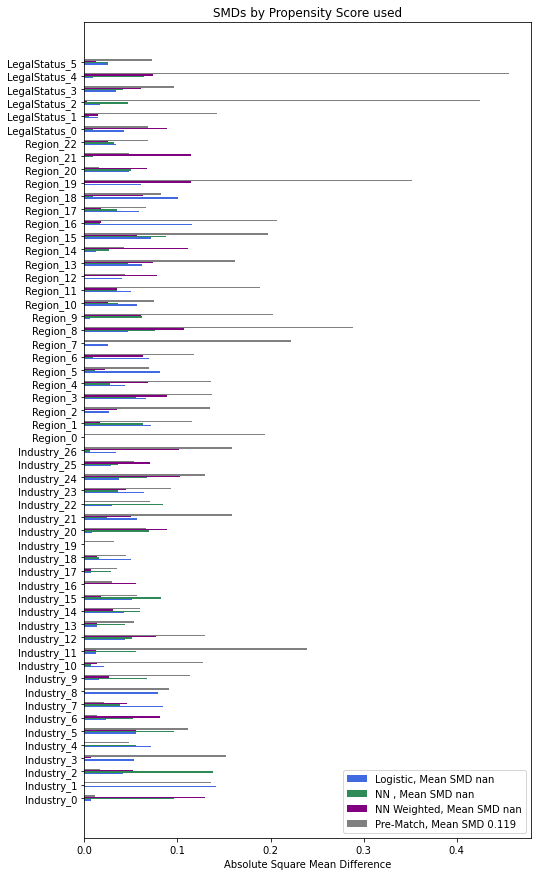

In [74]:
width = 0.1      # the width of the bars


ind = np.arange(len(indicators))

fig = plt.figure(figsize = (8,15))
ax = fig.add_subplot(111)
rects1 = ax.barh(ind, smds_log_indicators, width, color='royalblue')
rects2 = ax.barh(ind+width, smds_nn_indicators, width, color='seagreen')
rects3 = ax.barh(ind+width*2, smds_nn_w_indicators, width, color='purple')
rects4 = ax.barh(ind+width*3, smds_prematch_indicators, width, color='grey')

# add some
ax.set_xlabel('Absolute Square Mean Difference')
ax.set_title('SMDs by Propensity Score used')
ax.set_yticks(ind + 3*width / 2)
ax.set_yticklabels( indicators )

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0]), (f'Logistic, Mean SMD {round(np.mean(smds_log_indicators), 3)}', f'NN , Mean SMD {round(np.mean(smds_nn_indicators),3)}',f'NN Weighted, Mean SMD {round(np.mean(smds_nn_w_indicators),3)}', f'Pre-Match, Mean SMD {round(np.mean(smds_prematch_indicators),3)}'))

plt.show()

## Without Indicator Variables

In [75]:
## estimating the final model without fixed effects on the dummy variables. 

mod_l = sm.OLS(matched_logistic.iloc[:,0], matched_logistic.iloc[:,1:10])    # Describe model

res_l = mod_l.fit()       # Fit model


mod_nn = sm.OLS(matched_nn.iloc[:,0], matched_nn.iloc[:,1:10])    # Describe model

res_nn = mod_nn.fit()       # Fit model


mod_nn_w = sm.OLS(matched_nn_w.iloc[:,0], matched_nn_w.iloc[:,1:10])    # Describe model

res_nn_w = mod_nn_w.fit()       # Fit model


Stargazer([res_l, res_nn,res_nn_w])